## **0. Setup**

In [65]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet', 'yellow']

# set the directory where the data files are waiting
directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/nLD/RNAi/'
# directory = '/Users/ShokenLEE/Desktop/DATA/2022 10-12/P-235 siSun2 nLD'

In [66]:
micron_per_pixel = 0.23

## **1. Concanatate all the CSV files**

In [101]:
df = pd.DataFrame() # for nuclear protein and DAPI intensity data
df_LD = pd.DataFrame() # for LD data

for path, subdirs, files in os.walk(directory):
    for file in files:
        if (file.endswith('csv')) & ('ROI' not in file):
            _df = pd.read_csv(os.path.join(path, file))
            _df['Path'] = path
            df = pd.concat([df, _df], axis=0)
        elif (file.endswith('csv')) & ('ROI' in file):
            _df = pd.read_csv(os.path.join(path, file))
            df_LD = pd.concat([df_LD, _df], axis=0)

In [102]:
# rename columns
df = df.rename(columns={' ': 'ROI_number'})
df_LD = df_LD[[' ', 'Area', 'File name', 'ROI_number']]

In [118]:
# df.info()
df_LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1853 entries, 0 to 4
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0                  1853 non-null   object 
 1   Area           1853 non-null   float64
 2   File name      1853 non-null   object 
 3   ROI_number     1853 non-null   float64
 4   siRNA type     1853 non-null   object 
 5   Area_micronsq  1853 non-null   float64
dtypes: float64(3), object(3)
memory usage: 133.6+ KB


#### Check the number of files

In [104]:
print(len(df['File name'].unique()), len(df_LD['File name'].unique()))

99 99


## **2. Summerize LD data**

In [105]:
# total area and number (count) of LD per nucleus
df_LD_sumArea = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].sum().rename(columns={'Area': 'total_nLD_area'})
df_LD_count = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].count().rename(columns={'Area': 'number_of_nLD'})

# Merged the two above to summarize LD data
df_LD_summary = df_LD_count.merge(df_LD_sumArea, on=['File name', 'ROI_number'])

# Merge the LD data above to the df of nuclear protein and DAPI intensity data
df = df.merge(df_LD_summary, how='outer', on=['File name', 'ROI_number'])

# fill NA with 0
df.fillna(0, inplace=True)

In [161]:
# nLD area per nucleus
df['nLD_area_fraction'] = df.total_nLD_area / df.Area

# Relative nLD_are_fraction normalized to the mean value of control condition
mean_nLD_fraction_of_control = df[(df.number_of_nLD > 0) & (df['siRNA type'] == 'siCtrl')]['nLD_area_fraction'].mean()
df['Relative_nLD_area_fraction'] = df.nLD_area_fraction / mean_nLD_fraction_of_control

## **3. Group cell/condition types**

#### **Prepare column order for graphs**

In [76]:
# Groups (conditions) and its order in graphs
group_name_options = ['siRNA type', 'Plasmid type']
group_order_options = [
    ['siCtrl', 'siSun2', 'siSun1', 'siCTDNEP1'],
    ['Mock', 'WT', '2SA', '2SA_LVWA', 'Sun1']
]

group_name = group_name_options[0]
group_order = group_order_options[0]

# Hues
hue_name_options = ['Experiments', 'Sun2_OE']
hue_order_options = [
    ['t1', 't2'],
    ['(-)', '(+)']
]

hue_name = hue_name_options[0]
hue_order = hue_order_options[0]

#### **Cell type**

In [45]:
df.loc[df['File name'].str.contains('Sctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('CTDNEP1'), 'Cell type'] = 'CTDNEP1 KO'

#### **siRNA type**

In [107]:
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = group_order[0]
df.loc[df['File name'].str.contains('siSun2'), 'siRNA type'] = group_order[1]
df.loc[df['File name'].str.contains('siSun1'), 'siRNA type'] = group_order[2]
df.loc[df['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = group_order[3]

#### **Plasmid type**

In [15]:
df.loc[df['File name'].str.contains('mock'), 'Plasmid type'] = group_order[0]
df.loc[df['File name'].str.contains('WT '), 'Plasmid type'] = group_order[1]
df.loc[df['File name'].str.contains('SA '), 'Plasmid type'] = group_order[2]
df.loc[df['File name'].str.contains('SA-LVWA'), 'Plasmid type'] = group_order[3]
df.loc[df['File name'].str.contains('Sun1'), 'Plasmid type'] = group_order[4]

#### **Experiments**

In [108]:
df.loc[df['Path'].str.contains('P-225'), 'Experiments'] = hue_order[0]
df.loc[df['Path'].str.contains('P-235'), 'Experiments'] = hue_order[1]

#### **Sun2 OE Cutoff**

In [17]:
# Set the threshold
min_tag_intensity = 3000

# Sort Tag mean based on the threshold
df['Sun2_OE'] = df.apply(lambda x: '(+)' if x['Mean'] > min_tag_intensity else '(-)', axis=1)

#### **Select data only mock cells or cells with Sun2 OE detected**

In [27]:
_df = pd.concat([df[df['Sun2_OE'] == '(+)'], df[df['Plasmid type'] == 'Mock']], axis=0)

#### **Image number**

In [79]:
df['Image number'] = df['File name'].str[-7:-4]

# Check the number is correctly extracted
print(list(df['Image number'].unique())[1])

## **4. Analysis**

## **4-1. Sample size**

In [109]:
df.groupby([group_name, hue_name]).size()

siRNA type  Experiments
siCTDNEP1   t1             157
            t2             119
siCtrl      t1             174
            t2             170
siSun1      t1             175
            t2             176
siSun2      t1             142
            t2             116
dtype: int64

## **4-2. Frequency of cells that have nLD**

In [111]:
# _df_1: n of total cells; _df_2: n of cells with nLD
_df_1 = df.groupby([group_name, hue_name], as_index=False).size().rename(columns={'size': 'number_of_cells'})
_df_2 = df[df.number_of_nLD > 0].groupby([group_name, hue_name], as_index=False).size().rename(columns={'size': 'number_of_cells_w_nLD'})
df_n_cells = _df_1.merge(_df_2, on=[group_name, hue_name])

df_n_cells['% of cells with nLD'] = df_n_cells.number_of_cells_w_nLD / df_n_cells.number_of_cells * 100
df_n_cells.to_excel(directory + '/n_of_cells.xlsx', index_label=False)
df_n_cells

,siRNA type,Experiments,number_of_cells,number_of_cells_w_nLD,% of cells with nLD
0,siCTDNEP1,t1,157,54,34.394904
1,siCTDNEP1,t2,119,60,50.420168
2,siCtrl,t1,174,70,40.229885
3,siCtrl,t2,170,98,57.647059
4,siSun1,t1,175,93,53.142857
5,siSun1,t2,176,109,61.931818
6,siSun2,t1,142,72,50.704225
7,siSun2,t2,116,89,76.724138


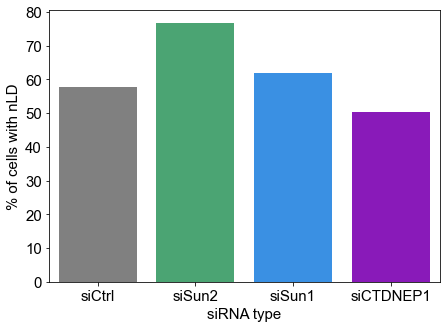

In [50]:
fig = plt.figure(figsize=(7,5))
ax = sns.barplot(data= df_n_cells, x=group_name, y='% of cells with nLD',
                 order=group_order,
                palette=my_pal)
# plt.legend(bbox_to_anchor=(1.05, 1), title='Sun2 OE', loc='upper left', borderaxespad=0)

In [51]:
fig.savefig(directory + '/%cells_w_nLD.pdf', bbox_inches='tight', transparent=True)

## **4-3. nLD area per nucleus**

Text(0, 0.5, 'Relative_area')

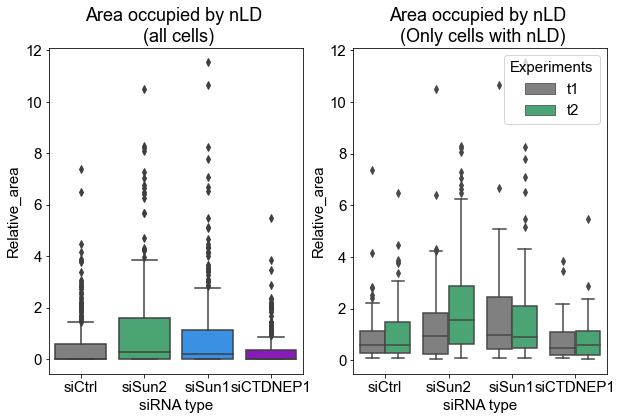

In [185]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1 = sns.boxplot(data=df, x=group_name, order=group_order, y='Relative_nLD_area_fraction', palette=my_pal)
plt.title('Area occupied by nLD \n (all cells)')
plt.ylabel('Relative_area')

ax2 = fig.add_subplot(122)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, hue=hue_name, hue_order=hue_order, y='Relative_nLD_area_fraction', palette=my_pal)
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Relative_area')

In [184]:
fig.savefig(directory + '/nLD_area_fraction.pdf', bbox_inches='tight', transparent=True)

In [187]:
df[df['number_of_nLD']>0].groupby([group_name, hue_name])['Relative_nLD_area_fraction'].mean()

siRNA type  Experiments
siCTDNEP1   t1             0.790715
            t2             0.865197
siCtrl      t1             0.929916
            t2             1.050060
siSun1      t1             1.637136
            t2             1.569853
siSun2      t1             1.410290
            t2             2.181643
Name: Relative_nLD_area_fraction, dtype: float64

In [173]:
res = pairwise_tukeyhsd(df[df.number_of_nLD > 0]['Relative_nLD_area_fraction'], df[df.number_of_nLD > 0]['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl   0.1701 0.7842 -0.3207 0.6608  False
siCTDNEP1 siSun1   0.7709  0.001  0.2971 1.2447   True
siCTDNEP1 siSun2   1.0068  0.001  0.5117 1.5018   True
   siCtrl siSun1   0.6008 0.0015  0.1785 1.0231   True
   siCtrl siSun2   0.8367  0.001  0.3906 1.2827   True
   siSun1 siSun2   0.2359 0.4866 -0.1914 0.6631  False
------------------------------------------------------


## **4-4. Number of nLD per nucleus**

(0.0, 20.0)

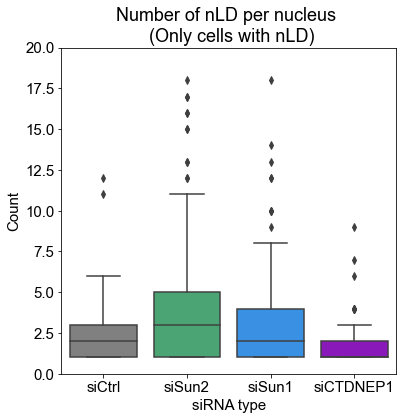

In [177]:
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(111)
ax1 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
plt.ylabel('Count')
plt.ylim([0,20])

In [179]:
df[df['number_of_nLD']>0].groupby(group_name)['number_of_nLD'].mean()

siRNA type
siCTDNEP1    1.771930
siCtrl       2.285714
siSun1       3.059406
siSun2       4.031056
Name: number_of_nLD, dtype: float64

In [178]:
res = pairwise_tukeyhsd(df[df.number_of_nLD > 0]['number_of_nLD'], df[df.number_of_nLD > 0]['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl   0.5138 0.3782 -0.3115  1.339  False
siCTDNEP1 siSun1   1.2875  0.001  0.4908 2.0842   True
siCTDNEP1 siSun2   2.2591  0.001  1.4267 3.0916   True
   siCtrl siSun1   0.7737 0.0265  0.0636 1.4838   True
   siCtrl siSun2   1.7453  0.001  0.9953 2.4954   True
   siSun1 siSun2   0.9716  0.003  0.2531 1.6902   True
------------------------------------------------------


## **4-5. Individual nLD size (not quantifiable with Sun2 OE experiment)**

Text(0, 0.5, 'Area (square micron)')

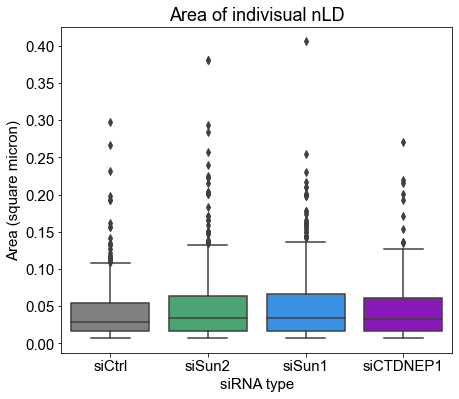

In [144]:
# group siRNA type
df_LD.loc[df_LD['File name'].str.contains('siCtrl'), 'siRNA type'] = group_order[0]
df_LD.loc[df_LD['File name'].str.contains('siSun2'), 'siRNA type'] = group_order[1]
df_LD.loc[df_LD['File name'].str.contains('siSun1'), 'siRNA type'] = group_order[2]
df_LD.loc[df_LD['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = group_order[3]

# convert pixel sq to micron sq
df_LD['Area_micronsq'] = df_LD.Area * np.square(micron_per_pixel)

fig = plt.figure(figsize=(7,6))
ax1 = sns.boxplot(data=df_LD, x=group_name, y='Area_micronsq', 
                  order=group_order, palette=my_pal)

# ax1.text(-1, 0.5, "Mean=")
# for xtick in ax1.get_xticks():
#     ax1.text(xtick-0.3, 0.5, xtick)

plt.title('Area of indivisual nLD')
plt.ylabel('Area (square micron)')

### Tukey test

In [180]:
res = pairwise_tukeyhsd(df_LD['Area_micronsq'], df_LD['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl  -0.0048 0.5855 -0.0146 0.0051  False
siCTDNEP1 siSun1   0.0018    0.9 -0.0074 0.0109  False
siCTDNEP1 siSun2   0.0021    0.9  -0.007 0.0112  False
   siCtrl siSun1   0.0065 0.1024 -0.0008 0.0138  False
   siCtrl siSun2   0.0069 0.0726 -0.0004 0.0141  False
   siSun1 siSun2   0.0003    0.9  -0.006 0.0067  False
------------------------------------------------------


In [145]:
df_LD.groupby(['siRNA type']).size()

siRNA type
siCTDNEP1    202
siCtrl       384
siSun1       618
siSun2       649
dtype: int64

In [146]:
fig.savefig(directory + '/Area_individual_nLD.pdf', bbox_inches='tight', transparent=True)

### Graphs of nLD area and number

Text(0, 0.5, 'Count')

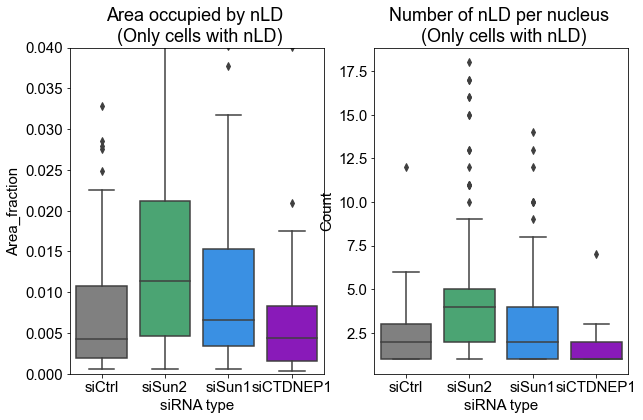

In [57]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(10,6))
# ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax1 = fig.add_subplot(2,2,1)
# ax1 = sns.boxplot(data=df, x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.title('Area occupied by nLD \n (All cells)')
# plt.ylabel('Area_fraction')
# # plt.legend(bbox_to_anchor=(1.05, 1), title='Sun2 OE', loc='upper left', borderaxespad=0)
# # plt.yscale('log')
# # ax1.spines['top'].set_visible(False)
# # ax_box.spines['right'].set_visible(False)

ax2 = fig.add_subplot(121)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
plt.ylim([0, 0.04])
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,2)
# ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.ylim([0.04, 0.1])
# plt.title('Area occupied by nLD \n (Only cells with nLD)')
# plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,3)
# ax3 = sns.boxplot(data=df, x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
# plt.title('Number of nLD per nucleus \n (All cells)')
# plt.ylabel('Count')
# # plt.yscale('log')

ax3 = fig.add_subplot(122)
ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
plt.ylabel('Count')
# # plt.yscale('log')

#### **C3 channel intensity (background subtracted)**

##### **C3 distribution**

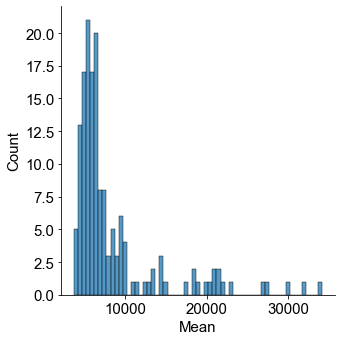

In [7]:
hist = sns.displot(x='Mean', data=df, binwidth=500)
# hist = sns.displot(x='Mean', data=df, col='Cell type', hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal, binwidth=500)

In [49]:
# df.groupby('Tag expression')['Mean'].min()
df['Mean'].min()

3180.545

##### **Background subtraction from C3 intensity value**

In [8]:
background_C3 = 1800

df['C3 mean - background'] = df['Mean'] - background_C3

#### **Scatter plot (nLD area vs Sun2 intensity)**

<Figure size 360x360 with 0 Axes>

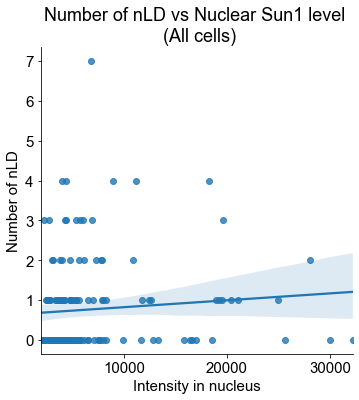

In [11]:
fig = plt.figure(figsize=(5, 5))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df, legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

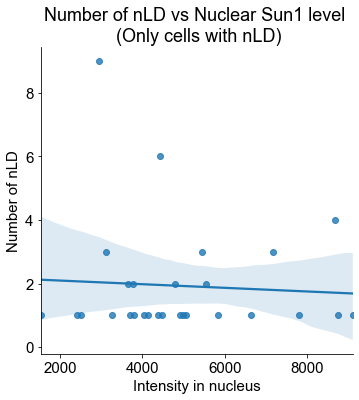

In [53]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

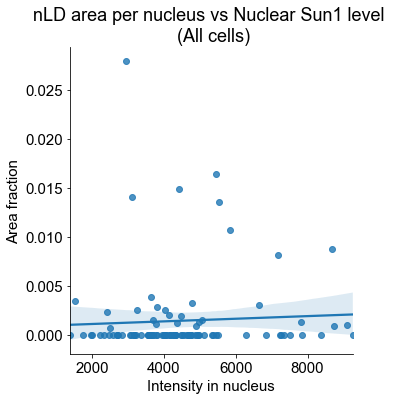

In [55]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df, legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun2_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

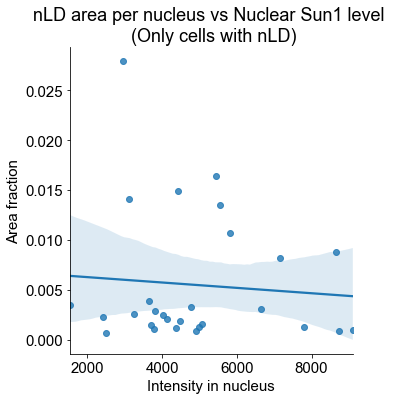

In [56]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

In [98]:
fig.savefig(directory + '/N_of_LD_vs_Sun2_nLD_cells.pdf', transparent=True, bbox_inches='tight')

#### **3-1. Mitotic cells**

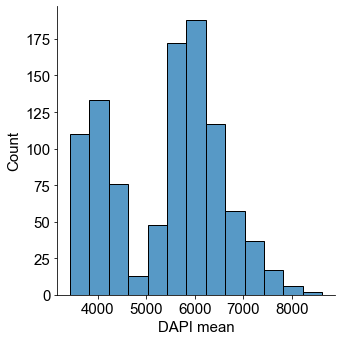

In [14]:
# hist = sns.displot(data=df, x='DAPI mean', hue='Cell type', hue_order=['Control', 'CTDNEP1 KO'], binwidth=400)
hist = sns.displot(data=df, x='DAPI mean', binwidth=400)
# plt.xlim([1000,4000])

#### **Remove cells with too hight DAPI intensity, which are likely mitotic cells**

In [32]:
max_DNA_intensity = 12000

df = df[df['DAPI mean'] < max_DNA_intensity]